# Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',50)
plt.style.use("fivethirtyeight")

## Read Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Mini Project/Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning/marketing_campaign_data.csv')
df.sample(5)

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1092,1092,4944,1959,S1,Bertunangan,71367000.0,0,0,23-08-2013,24,227000,23000,389000,42000,21000,75000,1,4,5,7,2,0,0,0,0,0,0,3,11,0
161,161,9260,1945,S3,Menikah,70356000.0,0,0,05-11-2012,20,1349000,16000,249000,43000,16000,33000,2,10,6,9,6,0,0,0,0,0,0,3,11,0
1816,1816,5782,1982,D3,Bertunangan,58582000.0,0,1,28-09-2013,15,402000,35000,106000,101000,77000,42000,2,9,2,9,5,0,1,0,0,0,0,3,11,0
1728,1728,1000,1961,S2,Bertunangan,74881000.0,1,1,08-03-2013,48,505000,72000,270000,36000,27000,54000,4,9,2,12,5,0,0,0,0,0,0,3,11,0
1356,1356,7912,1978,S1,Menikah,38136000.0,1,0,22-04-2013,69,8000,15000,27000,0,20000,33000,2,3,1,2,8,1,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

- Untuk Kolom Dt_Customer perlu diubah tipe datanya menjadi datetime.
- Pada kolom Income terdapat 24 Missing Values.

## 1. Conversion Rate Analysis Based on Income, Spending and Age

### Feature Engineering

#### Conversion Rate

Untuk melakukan Analisis Conversion Rate dari setiap Customer, kita perlu membuat kolom Conversion Rate terlebih dahulu. Conversion Rate merupakan persentase pengunjung website serta tindakan apa saja yang Customer lakukan selama mengunjungi situs. Pada Dataset ini kita akan memanfaatkan 2 Kolom yang ada untuk mencari Conversion Rate, yaitu :
- Kolom Total Transaction yang merupakan Jumlah Transaksi yang dilakukan Customer. Data Total Transaction bisa kita dapatkan dengan menjumlahkan Nilai dari Kolom NumDealsPurchases,	NumWebPurchases,	NumCatalogPurchases dan NumStorePurchases. 
  - Diasumsikan semua Pembelian adalah MECE (Mutually Exclusive and Collectively Exhaustive) dimana setiap Nilai dari kolom NumDealsPurchases,	NumWebPurchases,	NumCatalogPurchases dan	NumStorePurchases tidak ada yang Overlap atau muncul lebih di lebih dari satu kolom.
- Kolom NumWebVisitsMonth menunjukkan Jumlah kunjungan yang dilakukan Customer selama 1 Bulan terakhir.

In [5]:
# Total Transaction

df['TotalTransaction'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [6]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

In [7]:
df['ConversionRate'] = df.apply(lambda x : safe_div(x['TotalTransaction'], x['NumWebVisitsMonth']), axis = 1)

#### Age

In [8]:
from datetime import date as dt

In [9]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

df['Join_at_Age'] = df['Dt_Customer'].dt.year - df['Year_Birth']

In [10]:
now = dt.today()

In [11]:
current_year = now.year
current_year

2022

In [12]:
df['Age'] = current_year - df['Year_Birth']

Data Umur akan dikelompokkan menjadi beberapa Kategori untuk mempermudah analisis dengan ketentuan sebagai berikut :
- Child : Umur < 12 tahun
- Teens : Umur 12 - 17 tahun 
- Young Adults : Umur 18 - 35 tahun.
- Middle Adults : Umur 36 - 55 tahun.
- Senior Adults : Umur > 55 tahun.

In [13]:
def segment_age(x) :
  if x['Age'] < 12 :
    segment = 'Child'
  elif x['Age'] in range(12,18,1) :
    segment = 'Teens'
  elif x['Age'] in range(18,36,1) :
    segment = 'Young Adults'
  elif x['Age'] in range(36,56,1) :
    segment = 'Middle Adults'
  elif x['Age'] > 55 :
    segment = 'Senior Adults'
  return segment

In [14]:
df['AgeCtg'] = df.apply(lambda x: segment_age(x), axis=1)

#### Total Spending

In [15]:
df['TotSpending'] = df['MntCoke'] +df['MntFishProducts'] + df['MntFruits'] + df['MntGoldProds'] +df['MntMeatProducts'] + df['MntSweetProducts']

#### Total Accepted Campaign

In [16]:
df['TotalAccCmpg'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

#### Total Kids

In [17]:
df['total_kids'] = df['Kidhome'] + df['Teenhome']

#### Is Parents

In [18]:
df['is_parents'] = np.where(df['total_kids'] > 0, 1, 0)

### EDA

#### Descriptive Statistics

In [19]:
nums = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke', 
        'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
        'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue',
        'TotSpending', 'Age', 'Join_at_Age', 'total_kids'
        ]

cats = ['Education', 'Marital_Status',
        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
        'AcceptedCmp4', 'AcceptedCmp5', 'Complain',
        'Response', 'AgeCtg', 'is_parents'
        ]

In [20]:
df[nums].describe()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,TotSpending,Age,Join_at_Age,total_kids
count,2.216000e+03,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2.240000e+03,2240.000000,2240.000000,2240.000000
mean,5.224725e+07,0.444196,0.506250,49.109375,3.039357e+05,26302.232143,1.669500e+05,37525.446429,27062.946429,44021.875000,2.325000,4.084821,2.662054,5.790179,5.316518,3.0,11.0,6.057982e+05,53.194196,44.222321,0.950446
std,2.517308e+07,0.538398,0.544538,28.962453,3.365974e+05,39773.433765,2.257154e+05,54628.979403,41280.498488,52167.438915,1.932238,2.778714,2.923101,3.250958,2.426645,0.0,0.0,6.022493e+05,11.984069,12.022855,0.751803
min,1.730000e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,5.000000e+03,26.000000,16.000000,0.000000
25%,3.530300e+07,0.000000,0.000000,24.000000,2.375000e+04,1000.000000,1.600000e+04,3000.000000,1000.000000,9000.000000,1.000000,2.000000,0.000000,3.000000,3.000000,3.0,11.0,6.875000e+04,45.000000,36.000000,0.000000
50%,5.138150e+07,0.000000,0.000000,49.000000,1.735000e+05,8000.000000,6.700000e+04,12000.000000,8000.000000,24000.000000,2.000000,4.000000,2.000000,5.000000,6.000000,3.0,11.0,3.960000e+05,52.000000,43.000000,1.000000
75%,6.852200e+07,1.000000,1.000000,74.000000,5.042500e+05,33000.000000,2.320000e+05,50000.000000,33000.000000,56000.000000,3.000000,6.000000,4.000000,8.000000,7.000000,3.0,11.0,1.045500e+06,63.000000,54.000000,1.000000
max,6.666660e+08,2.000000,2.000000,99.000000,1.493000e+06,199000.000000,1.725000e+06,259000.000000,263000.000000,362000.000000,15.000000,27.000000,28.000000,13.000000,20.000000,3.0,11.0,2.525000e+06,129.000000,121.000000,3.000000


In [21]:
df[cats].describe()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response,is_parents
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,0.064286,0.013393,0.072768,0.074554,0.072768,0.009375,0.149107,0.715179
std,0.245316,0.114976,0.259813,0.262728,0.259813,0.096391,0.356274,0.451430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Multivariate Analysis

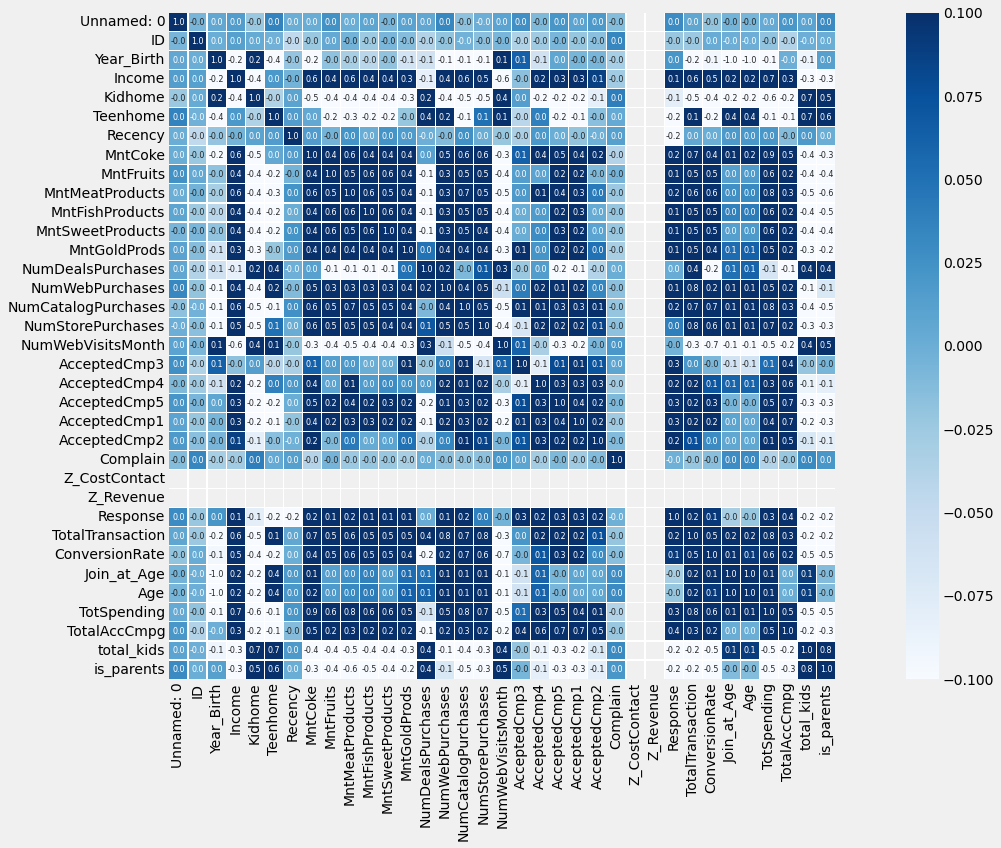

In [22]:
# correlation heatmap
plt.figure(figsize=(20, 12))

sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='.1f',
           vmin=df.corr().values.min(), vmax=1, square=True, linewidths=0.1, annot_kws={"fontsize":8})
plt.tight_layout()
plt.savefig('heatmap.png', dpi=200)

#### Income vs Total Spending

<Figure size 1080x576 with 0 Axes>

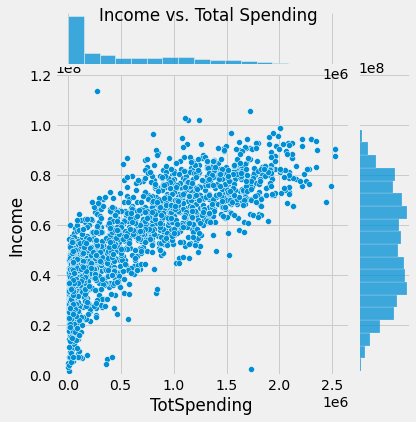

In [23]:
plt.figure(figsize=(15, 8))
plot = sns.jointplot(x=df["TotSpending"], y=df["Income"])
plt.suptitle('Income vs. Total Spending')
plot.ax_marg_y.set_ylim(0, 120000000)
plt.savefig('Income_vs_TotSpensing', dpi=200)

#### Income vs Age

<Figure size 1080x576 with 0 Axes>

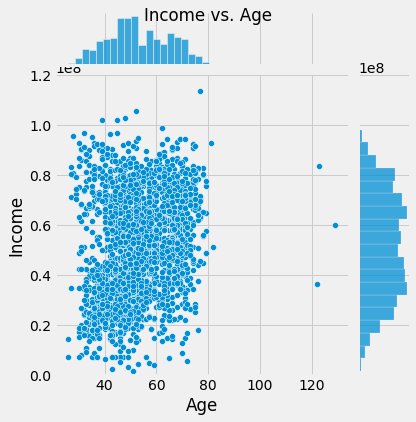

In [24]:
plt.figure(figsize=(15, 8))
plot = sns.jointplot(x=df["Age"], y=df["Income"])
plt.suptitle('Income vs. Age')
plot.ax_marg_y.set_ylim(0, 120000000)
plt.savefig('Income_vs_Age', dpi=200)

#### Total Spending vs Age

<Figure size 1080x576 with 0 Axes>

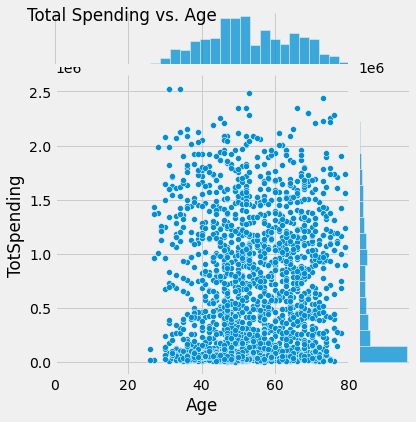

In [25]:
plt.figure(figsize=(15, 8))
plot = sns.jointplot(x=df["Age"], y=df["TotSpending"])
plt.suptitle('Total Spending vs. Age', x=0.3)
plot.ax_marg_x.set_xlim(0, 80)
plt.savefig('TotSpensing_vs_Age', dpi=200)

#### Conversion Rate vs Income, Total Spending & Age

<Figure size 1080x864 with 0 Axes>

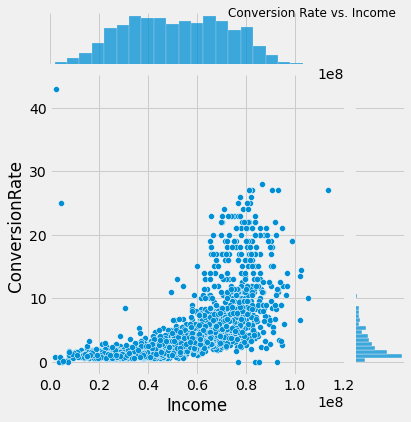

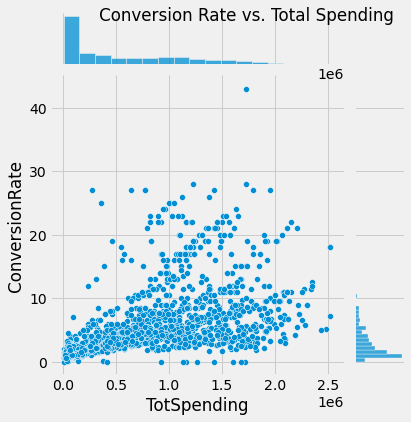

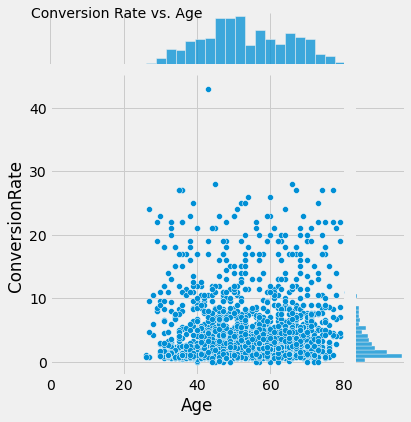

In [26]:
plt.figure(figsize=(15,12))

g0 = sns.jointplot(x=df["Income"], y=df["ConversionRate"])
plt.suptitle('Conversion Rate vs. Income', x=0.75, fontsize=12)
g0.ax_marg_x.set_xlim(0, 120000000)
plt.savefig('CVR_vs_Income', dpi=200)
plt.show()

g1 = sns.jointplot(x=df["TotSpending"], y=df["ConversionRate"])
plt.suptitle('Conversion Rate vs. Total Spending', x=0.6)
plot.ax_marg_y.set_ylim(0, 50)
plt.savefig('CVR_vs_TotSpending', dpi=200)
plt.show()

g2 = sns.jointplot(x=df["Age"], y=df["ConversionRate"])
plt.suptitle('Conversion Rate vs. Age', x=0.3, fontsize=14)
g2.ax_marg_x.set_xlim(0, 80)
plt.savefig('CVR_vs_Age', dpi=200)
plt.show()

## 2. Data Cleaning & Preprocessing

### Handling Missing Value

In [27]:
df.isnull().sum()

Unnamed: 0              0
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntCoke                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
TotalTransaction        0
ConversionRate          0
Join_at_Age             0
Age                     0
AgeCtg                  0
TotSpending             0
TotalAccCmpg            0
total_kids              0
is_parents  

Untuk Kolom Income terdapat 24 Missing Value (1,07% Data). Karena jumlahnya yang rendah maka kita bisa menghilangkan Data Missing Value tersebut.

In [28]:
df_clean = df.copy()

In [29]:
df_clean = df_clean.dropna()

### Handling Duplicated Data

In [30]:
df_clean.duplicated().sum()

0

Pada Dataset tidak terdapat Duplicated Data.

### Feature Encoding

In [31]:
df_preprocessing = df_clean.copy()

#### Education

In [32]:
mapping_education = {
    'SMA' : 0,
    'D3' : 1,
    'S1' : 2,
    'S2' : 3,
    'S3' : 4
}

In [33]:
df_preprocessing['Education'] = df_preprocessing['Education'].map(mapping_education)

#### Marital Status

In [34]:
marital_status = pd.get_dummies(df_preprocessing['Marital_Status'], prefix='Marital_Status')

In [35]:
df_preprocessing = df_preprocessing.join(marital_status)

#### Age Category

In [36]:
age_category = pd.get_dummies(df_preprocessing['AgeCtg'], prefix='is')

In [37]:
df_preprocessing = df_preprocessing.join(age_category)

### Scaling Data

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
df_scaled = df_preprocessing.drop(columns=['Unnamed: 0','ID','Year_Birth','Dt_Customer','Marital_Status',
                                           'Kidhome','Teenhome','Complain',	'Z_CostContact','Z_Revenue','Response','AgeCtg'])

In [40]:
nums = ['Income','Recency','MntCoke','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
        'NumDealsPurchases',	'NumWebPurchases',	'NumCatalogPurchases',	'NumStorePurchases',	'NumWebVisitsMonth',
        'TotalTransaction',	'ConversionRate',	'Join_at_Age',	'Age', 'TotSpending', 'TotalAccCmpg', 'total_kids']

for col in nums:
  df_scaled[col] = StandardScaler().fit_transform(df_scaled[[col]])

In [41]:
df_scaled.sample(5)

,Education,Income,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,TotalTransaction,ConversionRate,Join_at_Age,Age,TotSpending,TotalAccCmpg,total_kids,is_parents,Marital_Status_Bertunangan,Marital_Status_Cerai,Marital_Status_Duda,Marital_Status_Janda,Marital_Status_Lajang,Marital_Status_Menikah,is_Middle Adults,is_Senior Adults,is_Young Adults
1127,2,-0.211236,1.554407,-0.783070,-0.662463,-0.668930,-0.632770,-0.633880,-0.539831,-0.168231,-1.125881,-0.571082,-0.861830,-0.956381,0,0,0,0,0,-1.027596,-0.420937,-0.599615,-0.682609,-0.877748,-0.439265,2.741110,1,1,0,0,0,0,0,1,0,0
824,2,1.411499,0.414188,3.519354,0.292672,0.535177,0.225839,0.729885,-0.211669,-0.688176,0.333796,2.504712,-0.554143,0.280829,0,1,1,1,1,0.667490,-0.216343,0.814565,0.819538,2.239556,5.451271,0.070501,1,1,0,0,0,0,0,0,1,0
815,4,0.545180,-1.278863,0.210254,-0.436247,-0.374593,-0.340477,-0.560821,-0.771475,-0.168231,0.333796,0.454182,0.368919,-0.956381,0,0,0,0,0,0.406708,0.329243,-0.017306,-0.098441,-0.185936,-0.439265,0.070501,1,1,0,0,0,0,0,1,0,0
1958,2,1.771965,0.379636,0.423744,1.122132,3.496387,0.043156,-0.244233,-0.520527,-0.688176,0.698715,2.846467,1.291982,-1.368784,0,0,1,0,0,1.710620,1.966000,-1.764234,-1.767493,1.554379,1.033369,-1.264803,0,0,0,0,0,1,0,0,0,1
1345,2,-0.754876,-1.313416,-0.886850,-0.411112,-0.651091,-0.340477,-0.317292,-0.037937,-0.168231,-0.760962,-0.571082,-0.861830,0.280829,0,0,0,0,0,-0.897205,-0.625532,-0.516428,-0.515704,-0.821341,-0.439265,0.070501,1,0,0,0,0,1,0,1,0,0


## 3. Data Modelling

### FInding The Best Cluster using Elbow Method

In [42]:
from sklearn.cluster import KMeans

Akan dilakukan Feature Selection berdasarkan RFM Analysis dengan kolom yang akan dipilih yaitu :
- (Recency) Recency : Waktu terakhir Customer melakukan Transaksi.
- (Frequency) Conversion Rate : Frekuensi Transaksi/Kunjungan(Visits) yang dilakukan Customer.
- (Monetary) Income : Pendapatan Customer. 

In [43]:
new_df_scaled = df_scaled[['Recency', 'Income', 'ConversionRate']]

In [44]:
new_df_scaled.sample(5)

,Recency,Income,ConversionRate
269,-1.313416,-1.199061,-0.625532
114,-1.036999,-0.328729,-0.284541
2196,-0.829686,-0.354635,-0.664503
766,-1.417072,0.903461,0.840730
595,-1.278863,-1.382275,-0.635275


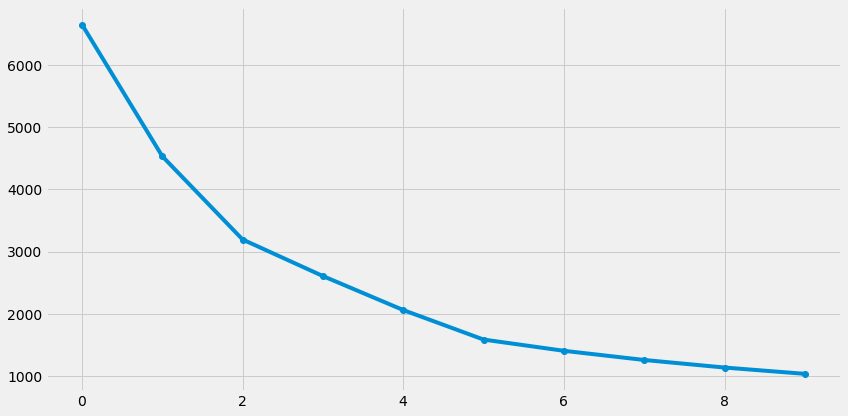

In [45]:
inertia = []

for i in range(1,11) :
  kmeans = KMeans(n_clusters = i, random_state=0)
  kmeans.fit(new_df_scaled.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(inertia,marker = 'o')
plt.tight_layout()
plt.savefig('elbow.png', dpi=200)

Berdasarkan grafik Elbow Method diatas kita dapat menggunakan Jumlah Cluster antara 4 s.d. 6. Pada Model ini akan digunakan Jumlah Cluster = 4.

### Clustering With K-Means

In [46]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(new_df_scaled.values)

KMeans(n_clusters=4, random_state=0)

In [47]:
clusters = kmeans.labels_
new_df = df_clean.copy()
new_df['clusters'] = clusters
new_df.sample(5)

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,TotalTransaction,ConversionRate,Join_at_Age,Age,AgeCtg,TotSpending,TotalAccCmpg,total_kids,is_parents,clusters
918,918,2625,1954,D3,Lajang,42607000.0,0,1,2013-11-17,30,156000,29000,56000,30000,32000,47000,2,3,2,7,3,0,0,0,0,0,0,3,11,0,14,4.666667,59,68,Senior Adults,350000,0,1,1,0
771,771,1915,1951,S3,Menikah,78939000.0,0,0,2013-12-12,57,794000,115000,243000,150000,0,205000,1,8,5,6,3,0,0,0,0,0,0,3,11,0,20,6.666667,62,71,Senior Adults,1507000,0,0,0,1
2146,2146,1818,1971,S3,Bertunangan,29732000.0,1,0,2014-03-25,23,25000,0,8000,0,1000,4000,1,2,0,2,9,0,0,0,0,0,0,3,11,0,5,0.555556,43,51,Middle Adults,38000,0,1,1,0
228,228,460,1972,S3,Menikah,79930000.0,0,0,2012-08-08,72,792000,86000,740000,67000,51000,17000,1,3,5,8,2,0,0,0,0,0,0,3,11,0,17,8.500000,40,50,Middle Adults,1753000,0,0,0,1
1807,1807,3130,1964,S1,Lajang,18701000.0,1,1,2013-04-06,95,12000,4000,2000,10000,6000,10000,4,2,0,4,5,0,0,0,0,0,0,3,11,0,10,2.000000,49,58,Senior Adults,44000,0,2,1,2


### Silhoutte Score

In [48]:
from sklearn.metrics import silhouette_score

In [49]:
range_n_clusters = list(range(2,11))
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i,random_state=0).fit(new_df_scaled)
    preds = kmeans.predict(new_df_scaled)
     
    score_euclidean = silhouette_score(new_df_scaled, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

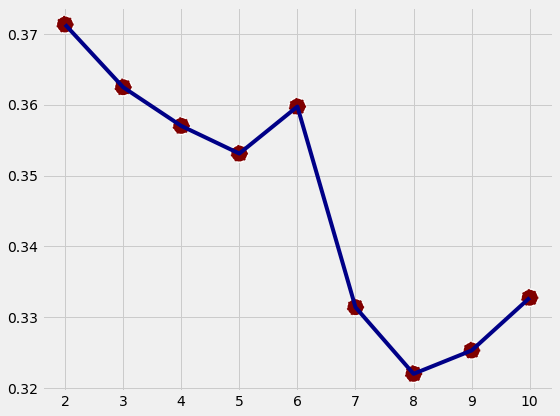

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')

plt.tight_layout()
plt.savefig('silhoette.png', dpi=200)
plt.show()

Meskipun Jumlah Cluster 6 memiliki Score yg sedikit tinggi dibandingkan Jumlah Cluster 4, Jumlah Cluster 4 akan lebih menghasilkan Cluster yang lebih baik dalam memberikan Insight bagi Tim Bisnis/Marketing  untuk meningkatkan Bisnis Perusahaan. Hal Tersebut akan diperlihatkan dalam Grafik Cluster. 

## 4. Customer Personality Analysis for Marketing Retargeting

### PCA

In [51]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)

pca.fit(new_df_scaled)
pcs = pca.transform(new_df_scaled)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca.head()

,PC 1,PC 2
0,0.045587,0.309040
1,-0.625751,-0.385073
2,0.671971,-0.794621
3,-1.158044,-0.798664
4,0.077437,1.553219


In [52]:
df_pca['clusters'] = clusters
df_pca.head(5)

,PC 1,PC 2,clusters
0,0.045587,0.309040,2
1,-0.625751,-0.385073,0
2,0.671971,-0.794621,1
3,-1.158044,-0.798664,0
4,0.077437,1.553219,2


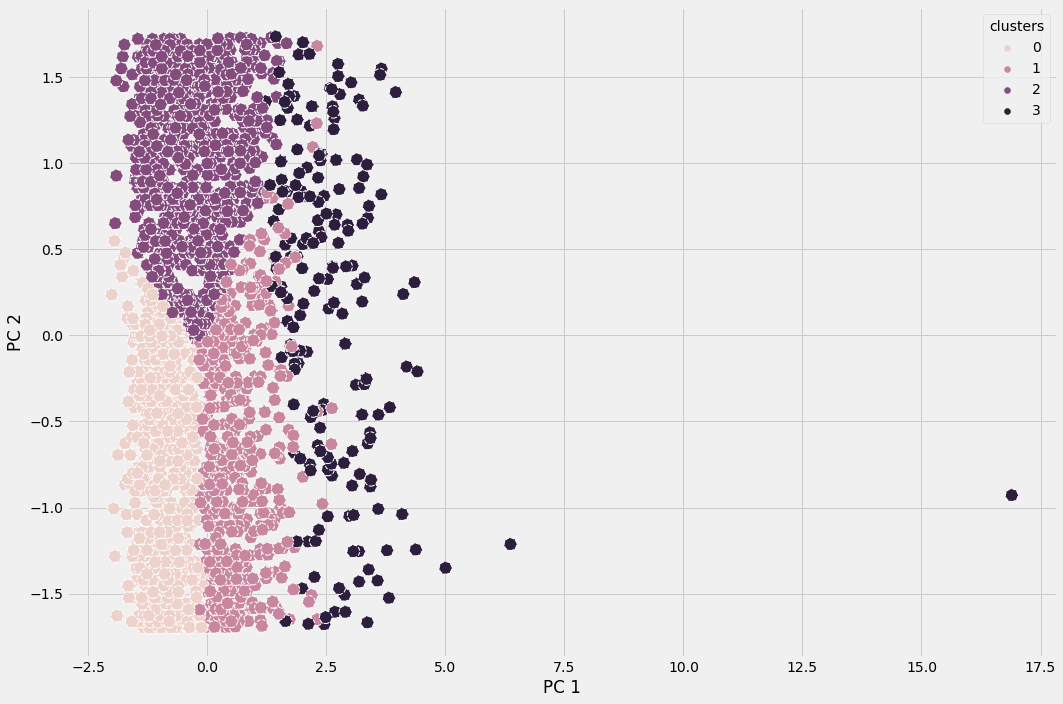

In [53]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=df_pca,
    s=160,
    ax=ax
)

plt.tight_layout()
plt.savefig('cluster',dpi=200)
plt.show()

- Terlihat pada Grafik bahwa Customer dikelompokkan menjadi 4 Cluster. 
- Jika kita perhatikan terdapat 1 Titik yang terletak jauh dari Titik lainnya.
- Titik tersebut akan mempengaruhi Clustering yang akan kita buat jika jumlah Cluster diubah menjadi lebih dari 4 Cluster, dimana akan terdapat sebuah Cluster dengan anggota Cluster hanya satu titik saja (titik terjauh tersebut). 
- Hal tersebut tentu tidak akan bisa membantu Tim Bisnis/Marketing dalam memberikan Insight bagi mereka untuk menyusun strategi bisnis berdasarkan Cluster kedepannya.

In [54]:
col = ['Income','Recency','ConversionRate','TotSpending', 'NumDealsPurchases',	'NumWebVisitsMonth', 'clusters']

new_df[col].groupby('clusters').agg(['mean','count'])

Income          Recency       ConversionRate        \
                  mean count       mean count           mean count   
clusters                                                             
0         3.426563e+07   673  27.369985   673       1.469960   673   
1         7.057009e+07   512  29.564453   512       5.629227   512   
2         4.784832e+07   818  77.654034   818       2.834513   818   
3         8.191233e+07   213  54.150235   213      16.618936   213   

           TotSpending       NumDealsPurchases       NumWebVisitsMonth        
                  mean count              mean count              mean count  
clusters                                                                      
0         1.510327e+05   673          2.369985   673          6.717682   673  
1         1.095934e+06   512          2.433594   512          4.232422   512  
2         4.858557e+05   818          2.536675   818          5.881418   818  
3         1.338432e+06   213          1.093897   213          1.352113   213

In [55]:
map_cluster = {
    0 : 'Low Spender',
    1 : 'Mid Spender',
    2 : 'Risk of Churn',
    3 : 'High Spender'
}

new_df['cluster_mapped'] = new_df['clusters'].map(map_cluster)

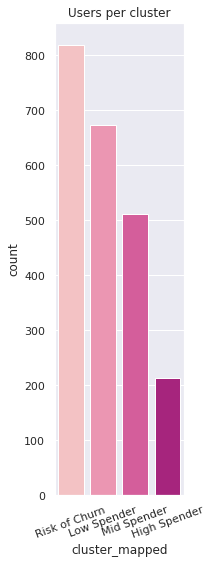

In [59]:
sns.set(rc={'figure.figsize':(3,8)})
color = sns.color_palette('RdPu')[1:]
sns.countplot(x=new_df['cluster_mapped'], palette=color)
plt.title('Users per cluster')
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig('User_per_cluster', dpi=200)

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
plt.style.use("fivethirtyeight")

### Income per Cluster

In [ ]:
sns.boxenplot(x=new_df['cluster_mapped'], y=new_df['Income'])
plt.title('Total Income per Cluster')
plt.ylim(0, 200000000)

### Recency per Cluster

In [ ]:
sns.boxenplot(x=new_df['cluster_mapped'], y=new_df['Recency'])
plt.title('Recency per Cluster')

### Conversion Rate per Cluster

In [ ]:
sns.boxenplot(x=new_df['cluster_mapped'], y=new_df['ConversionRate'])
plt.title('Conversion Rate per Cluster')

### Total Spending per Cluster

In [ ]:
sns.boxenplot(x=new_df['cluster_mapped'], y=new_df['TotSpending'])
plt.title('Total Spending per Cluster')

### Number Deals Purchases per Cluster

In [ ]:
sns.boxenplot(x=new_df['cluster_mapped'], y=new_df['NumWebVisitsMonth'])
plt.title('Number Deals Purchases per Cluster')

### Number Web Visit per Cluster

In [ ]:
sns.boxenplot(x=new_df['cluster_mapped'], y=new_df['NumDealsPurchases'])
plt.title('Number Web Visits Month per Cluster')

### Age Category per Cluster

In [ ]:
new_df.groupby(['cluster_mapped','AgeCtg'])['clusters'].count()

### Marital Status per Cluster

In [ ]:
new_df.groupby(['cluster_mapped','Marital_Status','is_parents'])['clusters'].count()

### Interpretation Cluster Summary

Kesimpulan :

- High Spender (Cluster 3) :
  - Merupakan Cluster dengan jumlah Customer terendah yaitu 213 Orang didominasi oleh Customer Senior Adults (>55 tahun) dan Middle Adults (36-55 tahun), yang didominasi telah/belum menikah dan belum mempunyai anak.
  - Merupakan Customer dengan Income & Total Spending tertinggi, yang masing - masing sebesar IDR 81 juta untuk total Income setahun, dan IDR 1,3 juta untuk total spending dalam setahun.
  - Memiliki Nilai Recency tertinggi kedua.
  - Memiliki Nilai Conversion Rate tertinggi dan Jumlah Kunjungan Web terendah. 
  - Merupakan Customer dengan pembelian menggunakan Deals/Promo terendah.
  - Merupakan __Customer Champions__.

- Mid Spender (Cluster 1) :
  - Merupakan Cluster dengan jumlah Customer terendah kedua yaitu 512 Orang didominasi oleh Customer Senior Adults (>55 tahun) dan Middle Adults (36-55 tahun), yang didominasi telah menikah dan sudah mempunyai anak.
  - Merupakan Customer dengan Total Spending & Income tertinggi kedua, yang masing - masing sebesar IDR 70 juta untuk total Income setahun, dan IDR 1 juta untuk total spending dalam setahun.
  - Memiliki Nilai Recency terendah kedua.
  - Memiliki Nilai Conversion Rate tertinggi kedua dan Jumlah Kunjungan Web terendah kedua.
  - Memiliki jumlah Customer dengan pembelian menggunakan Deals/Promo tertinggi kedua.
  - Merupakan __Customer Potential__.

- Low Spender (Cluster 0) :
  - Merupakan Cluster dengan jumlah Customer terbanyak kedua yaitu 673 Orang didominasi oleh Customer Middle Adults (36-55 tahun), yang didominasi telah menikah dan sudah mempunyai anak.
  - Merupakan Customer dengan Total Spending & Income terendah, yang masing - masing sebesar IDR 34 juta untuk total Income setahun, dan IDR 150K untuk total spending dalam setahun.
  - Memiliki Nilai Recency terendah.
  - Memiliki Nilai Conversion Rate terendah dan Jumlah Kunjungan Web tertinggi. 
  - Memiliki jumlah Customer dengan pembelian menggunakan Deals/Promo tertinggi ketiga.
  - Merupakan __Customer Need Attention__.

- Risk of Churn (Cluster 2) :
  - Merupakan Cluster dengan jumlah Customer terbanyak yaitu 818 Orang didominasi oleh Customer Middle Adults (36-55 tahun), yang didominasi telah menikah dan sudah mempunyai anak.
  - Merupakan Customer dengan Total Spending & Income terendah kedua, yang masing - masing sebesar IDR 47 juta untuk total Income setahun, dan IDR 480K untuk total spending dalam setahun.
  - Memiliki Nilai Recency tertinggi.
  - Memiliki Nilai Conversion Rate terendah kedua dan Jumlah Kunjungan Web tertinggi kedua. 
  - Memiliki jumlah Customer dengan pembelian menggunakan Deals/Promo tertinggi.
  - Merupakan __Customer At Risk__.

### Recommendation & Potential Impact

- Recommendation :
  - Untuk kelompok High Spender harus kita pertahankan, kita dapat berupaya meningkatkan pelayanan dan membuat strategi bisnis khusus untuk kelompok ini agar mereka tidak churn.
  - Untuk kelompok Mid Spender cukup sering mengunjungi web dan bertransaksi menggunakan deals/promo. Kita dapat menganalisis lebih lanjut agar dapat mengoptimasikan deals/promo yang diberikan dengan mengurangi cost yang dikeluarkan saat memberikan deals/promo untuk kelompok ini dengan tetap membuat mereka berbelanja di platform kita.
  - Untuk kelompok Low Spender dan Risk of Churn merupakan customer - customer yang paling sering mengunjungi web tetapi tidak melakukan transaksi. Hal tersebut dapat disebabkan oleh Harga atau Promo yang kurang cocok bagi kelompok - kelompok ini. Maka kita dapat melakukan analisis lebih lanjut untuk meningkatkan Conversion Rate dari kelompok - kelompok ini.

In [ ]:
# Total Spend Cluster High Spending
new_df[new_df.clusters == 3].TotSpending.sum()

In [ ]:
# Total Spend Cluster Mid Spending
new_df[new_df.clusters == 1].TotSpending.sum()

In [ ]:
# Jumlah yang dapat disave jika diasumsikan berhasil mengurangi cost sebesar 40%
((new_df[new_df.clusters == 1].TotSpending.sum()/new_df[new_df.clusters == 1].TotalTransaction.sum())*new_df[new_df.clusters == 1].NumDealsPurchases.sum())*0.4

- Business Impact :
  - Jika kita dapat mempertahankan Kelompok High Spender dan Mid Spender kita berpotensi mendapatkan GMV masing - masing sebesar IDR 285 juta dan IDR 561 juta.
  - Jika kita berhasil mengoptimasikan promo yang diberikan kepada kelompok Mid Spender (dengan asumsi reduksi sebesar 40%), maka kita dapat mengurangi cost sebesar IDR 25 juta.